In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig


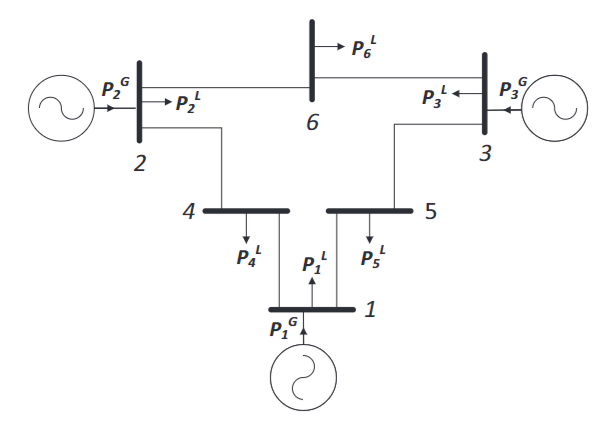

system state equation:
$$X\cdot \dot{s}=Y\cdot s+P$$


In [9]:
NG= 3
NL= 6
dt= 0.01

IMat= np.eye(NG)
MMat= np.diag([0.125, 0.034, 0.016]) # diagonal matrices filling with generator inertia
DMat= np.diag([0.125, 0.068, 0.032]) # diagonal matrices filling with generator damping
KIMat= np.diag([-35, -40, -35]) #diagonal matrices filling with generator integral coefficient
KPMat= np.diag([-2, -9, -3]) #diagonal matrices filling with generator proportional coefficient
BMat= np.array([[-17.4, 0, 0, 17.4, 0, 0, 0, 0, 0],
                [0, -16, 0, 0, 16, 0, 0, 0, 0],
                [0, 0, -17.1, 0, 0, 17.1, 0, 0, 0],
                [17.4, 0, 0, -24.3, 0, 0, 3.5, 3.4, 0],
                [0, 16, 0, 0, -46.3, 0, 16.4, 0, 13.9],
                [0, 0, 17.1, 0, 0, -53.8, 0, 16.7, 20],
                [0, 0, 0, 3.5, 16.4, 0, -19.9, 0, 0],
                [0, 0, 0, 3.4, 0, 16.7, 0, -20.1, 0],
                [0, 0, 0, 0, 13.9, 20, 0, 0, -33.9]])# admittance matrix
BGGMat= BMat[: NG, :NG]
BLLMat= BMat[NG:, NG:]
BGLMat= BMat[:NG, NG:]
BLGMat= BMat[NG:, :NG]
PL= np.ones((NL, 1))
P= np.zeros((2*NG+NL, 1))
P[2*NG:]= PL

XMat= np.zeros((2*NG+NL,2*NG+NL))
XMat[:NG, :NG]= IMat
XMat[NG: 2*NG, NG: 2*NG]= MMat
YMat= np.zeros((2*NG+NL,2*NG+NL))
YMat[:NG, NG:2*NG]= IMat
YMat[NG:2*NG, :NG]= KIMat-BGGMat
YMat[NG:2*NG, NG:2*NG]= KPMat-DMat
YMat[NG:2*NG, 2*NG:]= -BGLMat
YMat[2*NG:, :NG]= BLGMat
YMat[2*NG:, 2*NG:]= BLLMat

stateInitial= np.linalg.inv(YMat).dot(-P)

state update equation:
$$ \dot{s}=(x-y\Delta t)^{-1}\cdot (y\cdot s_{t-1}+P)$$

In [10]:
def delta_s(X, Y, S, P, dt):
    tempMat= X-Y*dt
    tempMatInv= np.linalg.inv(tempMat)
    return tempMatInv.dot(Y.dot(S)+P)

def simulate(X, Y, S, P, dt, T, NG, NL):
    Ss= []
    ts= []
    Ps= []
    KL= Y[2*NG: , NG: 2*NG]
    print(KL.dot(S[NG: 2*NG]).shape)
    for i in range(0, int(T/dt)):
        t= i*dt
        if t>1: #load change
            P[-3]= 2
        Ps.append(P.copy())
        Ps[-1][2*NG:]+= KL.dot(S[NG: 2*NG]) # add attack load
        ts.append(t)
        sDot= delta_s(X, Y, S, P, dt)
        S= S+sDot*dt
        Ss.append(S)
    statesNp= np.stack(Ss).squeeze()
    PsNp= np.stack(Ps).squeeze()
    return ts, statesNp, PsNp
ts, statesNp, PsNp= simulate(XMat, YMat, stateInitial.copy(), P.copy(), dt, 5, NG, NL)


(6, 1)


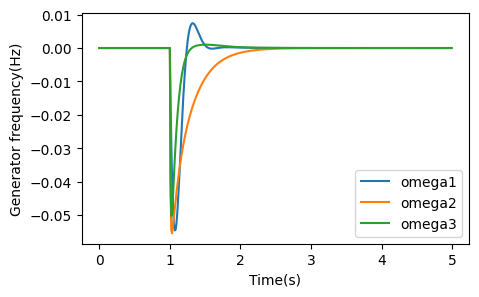

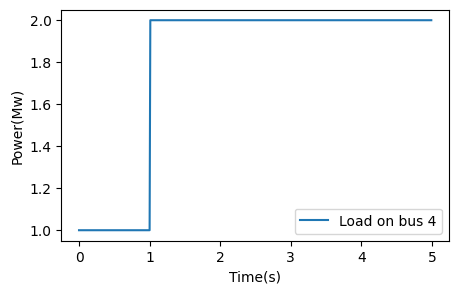

In [14]:
plt.figure(figsize=(5,3))
pltLabel= ["delta1", "delta2", "delta3", "omega1", "omega2", "omega3", "theta1", "theta2", "theta3", "theta4", "theta5", "theta6"]
plt.plot(ts, statesNp[:, NG: 2*NG], label= pltLabel[NG: 2*NG])
plt.xlabel("Time(s)")
plt.ylabel("Generator frequency(Hz)")
plt.legend(loc='lower right')

plt.figure(figsize=(5,3))
plt.plot(ts, PsNp[:, -3], label= "Load on bus 4")
plt.xlabel("Time(s)")
plt.ylabel("Power(Mw)")
plt.legend(loc='lower right')

(6, 1)


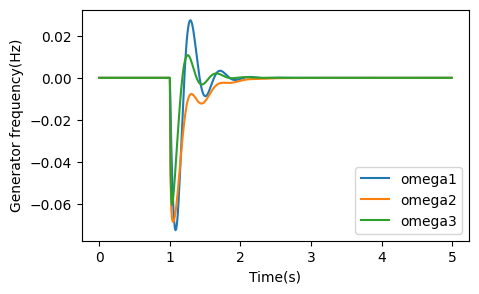

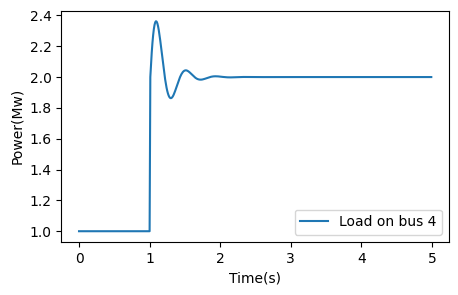

In [15]:
KLMat= np.zeros((NL, NG))
KLMat[3, 0]= 5
YMat[2*NG: , NG: 2*NG]= -KLMat
ts, statesNp, PsNp= simulate(XMat, YMat, stateInitial.copy(), P.copy(), dt, 5, NG, NL)

plt.figure(figsize=(5,3))
pltLabel= ["delta1", "delta2", "delta3", "omega1", "omega2", "omega3", "theta1", "theta2", "theta3", "theta4", "theta5", "theta6"]
plt.plot(ts, statesNp[:, NG: 2*NG], label= pltLabel[NG: 2*NG])
plt.xlabel("Time(s)")
plt.ylabel("Generator frequency(Hz)")
plt.legend(loc='lower right')

plt.figure(figsize=(5,3))
plt.plot(ts, PsNp[:, -3], label= "Load on bus 4")
plt.xlabel("Time(s)")
plt.ylabel("Power(Mw)")
plt.legend(loc='lower right')

(6, 1)


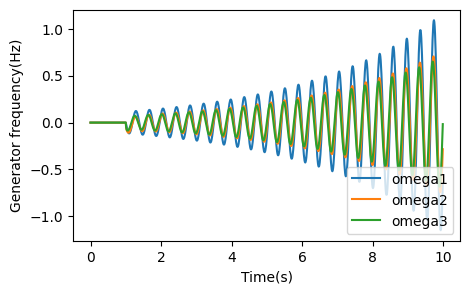

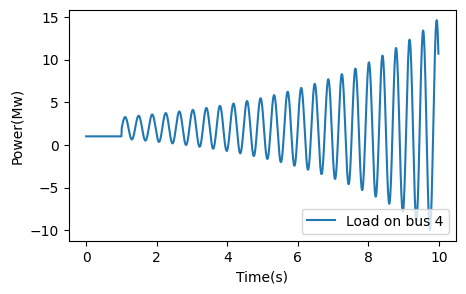

In [16]:
KLMat= np.zeros((NL, NG))
KLMat[3, 0]= 11
YMat[2*NG: , NG: 2*NG]= -KLMat
ts, statesNp, PsNp= simulate(XMat, YMat, stateInitial.copy(), P.copy(), dt, 10, NG, NL)

plt.figure(figsize=(5,3))
pltLabel= ["delta1", "delta2", "delta3", "omega1", "omega2", "omega3", "theta1", "theta2", "theta3", "theta4", "theta5", "theta6"]
plt.plot(ts, statesNp[:, NG: 2*NG], label= pltLabel[NG: 2*NG])
plt.xlabel("Time(s)")
plt.ylabel("Generator frequency(Hz)")
plt.legend(loc='lower right')

plt.figure(figsize=(5,3))
plt.plot(ts, PsNp[:, -3], label= "Load on bus 4")
plt.xlabel("Time(s)")
plt.ylabel("Power(Mw)")
plt.legend(loc='lower right')

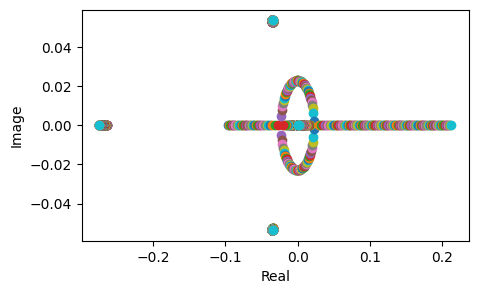

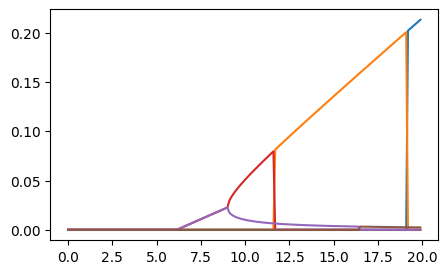

In [37]:
plt.figure(figsize=(5,3))# pole 
values= []
res= []
for i in range(200):
    value= i/10
    KLMat= np.zeros((NL, NG))
    KLMat[5, 2]= value
    values.append(value)
    YMat[2*NG: , NG: 2*NG]= -KLMat
    eigenvalues, eigenvectors = eig(XMat, YMat)
    plt.scatter(np.real(eigenvalues[:2*NG]), np.imag(eigenvalues[:2*NG]))
    res.append((np.real(eigenvalues[:2*NG])>0.00001)*np.real(eigenvalues[:2*NG]))
plt.xlabel("Real")
plt.ylabel("Image")
plt.figure(figsize=(5,3))
plt.plot(values, res)
#19, 13, 13
#inf, inf, 5
#10, 16, 15
#10, inf, 5
#inf, inf, 6